In [1]:
import kagglehub

path = kagglehub.dataset_download("nuranfarhanaprova/processed-rice-varieties-of-bangladesh")

print("Path to dataset files:", path)

100%|██████████| 240M/240M [00:03<00:00, 66.6MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/nuranfarhanaprova/processed-rice-varieties-of-bangladesh/versions/1


Aush: Attempting RGBe to RGB conversion.
BR-28: Attempting RGBe to RGB conversion.
BR-29: Attempting RGBe to RGB conversion.
Beroi: Attempting RGBe to RGB conversion.
Chinigura: Attempting RGBe to RGB conversion.
Ghee Bhog: Attempting RGBe to RGB conversion.
Katari Najir: Attempting RGBe to RGB conversion.
Katari Siddho: Attempting RGBe to RGB conversion.
Miniket: Attempting RGBe to RGB conversion.
Swarna: Attempting RGBe to RGB conversion.


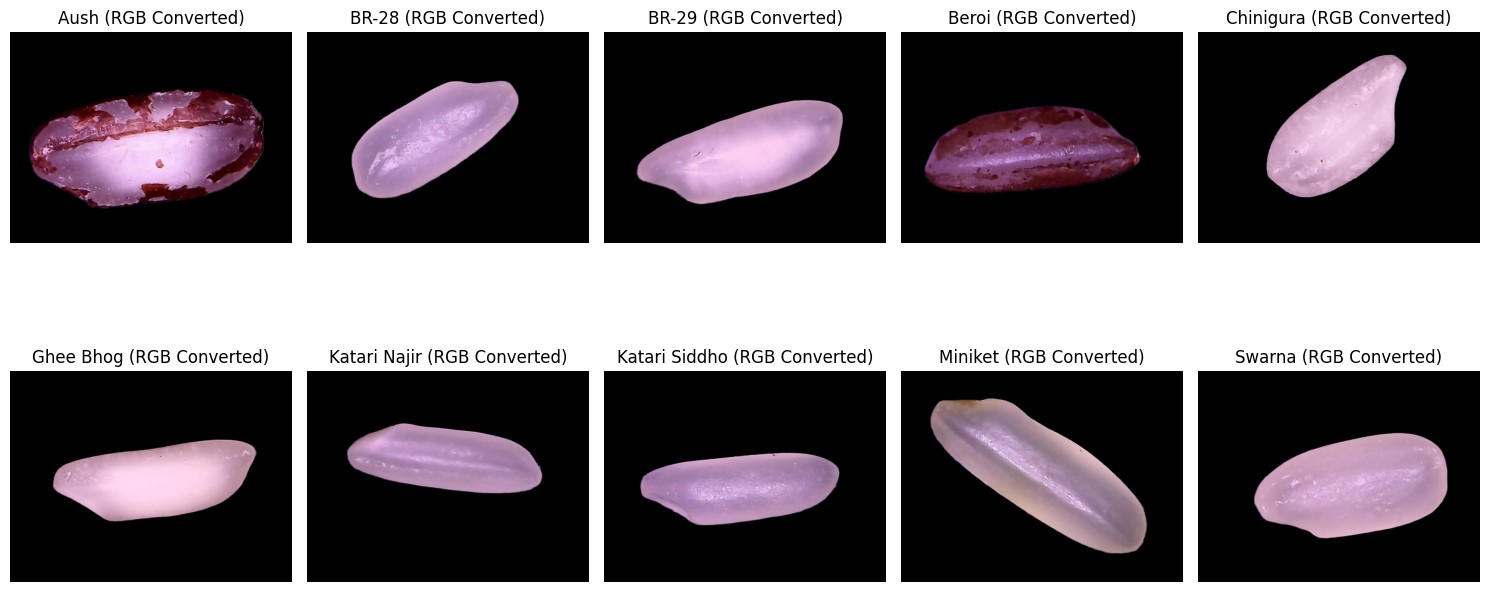

In [2]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

# ---------- Function: RGBe → RGB (smooth, non-binary) ----------
def rgbe_to_rgb(img):
    """Converts a 4-channel RGBe image to smooth RGB (0-255)."""
    if img is None or img.ndim != 3 or img.shape[2] != 4:
        print("Warning: Input is not a valid 4-channel image for RGBe conversion.")
        return None

    r, g, b, e = cv2.split(img.astype(np.float32))
    scale = np.exp2(e - 128.0)
    rgb = np.stack([(r / 255) * scale, (g / 255) * scale, (b / 255) * scale], axis=-1)

    # Normalize to 0-255 without binary mapping
    rgb_min, rgb_max = rgb.min(), rgb.max()
    if rgb_max - rgb_min > 0:
        rgb = (rgb - rgb_min) / (rgb_max - rgb_min)
    else:
        rgb = np.zeros_like(rgb)
    rgb = (rgb * 255).astype(np.uint8)

    return rgb

# ---------- Folder paths ----------
dataset_dir = "/root/.cache/kagglehub/datasets/nuranfarhanaprova/processed-rice-varieties-of-bangladesh/versions/1/Original_Images"

if not os.path.exists(dataset_dir):
    print(f"Error: Dataset directory not found at {dataset_dir}. Please ensure the dataset is downloaded and extracted correctly.")
else:
    classes = sorted(os.listdir(dataset_dir))

    plt.figure(figsize=(15, 8))

    for i, cls in enumerate(classes):
        class_path = os.path.join(dataset_dir, cls)

        if not os.path.isdir(class_path):
            print(f"Skipping {cls}: Not a directory.")
            continue

        image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        if not image_files:
            print(f"{cls}: No image files found, skipping.")
            continue

        img_path = os.path.join(class_path, image_files[0])
        img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)

        img_to_display = None
        title_text = cls

        if img is not None and isinstance(img, np.ndarray):
            if img.ndim == 3:  # Color images
                if img.shape[2] == 4:  # RGBe
                    print(f"{cls}: Attempting RGBe to RGB conversion.")
                    img_rgb = rgbe_to_rgb(img)
                    if img_rgb is not None:
                        img_to_display = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)
                        title_text += " (RGB Converted)"
                    else:
                        print(f"{cls}: Failed RGBe to RGB conversion.")
                elif img.shape[2] == 3:  # Normal RGB
                    print(f"{cls}: Normal RGB image, using directly.")
                    img_to_display = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_BGR2RGB)
                    title_text += " (Original RGB)"
                else:
                    print(f"{cls}: Unsupported number of channels ({img.shape[2]}), skipping.")
            elif img.ndim == 2:  # Grayscale
                print(f"{cls}: Grayscale image, skipping for visualization.")
            else:
                print(f"{cls}: Unsupported number of dimensions ({img.ndim}), skipping.")
        else:
            print(f"{cls}: Could not load image at {img_path} or it is not a valid numpy array, skipping.")

        # Plotting
        plt.subplot(2, (len(classes) + 1) // 2, i + 1)
        if img_to_display is not None:
            plt.imshow(img_to_display)
            plt.title(title_text)
        else:
            plt.text(0.5, 0.5, "Image Skipped", horizontalalignment='center', verticalalignment='center')
            plt.title(title_text + " (Skipped)")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


In [3]:
import os
import shutil
import numpy as np

dataset_dir = "/root/.cache/kagglehub/datasets/nuranfarhanaprova/processed-rice-varieties-of-bangladesh/versions/1/Original_Images"
split_base_dir = '/kaggle/working/split_data'

classes = [d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))]

splits = ['train', 'val', 'test']

# Create split directories
for split in splits:
    for cls in classes:
        os.makedirs(os.path.join(split_base_dir, split, cls), exist_ok=True)

# Perform split
for cls in classes:
    class_dir = os.path.join(dataset_dir, cls)
    images = sorted(os.listdir(class_dir))
    np.random.shuffle(images)

    total = len(images)

    # Step 1: 90:10 train:test
    train_val_end = int(total * 0.9)
    train_val_images = images[:train_val_end]
    test_images = images[train_val_end:]

    # Step 2: Within training portion, 10% for validation
    val_end = int(len(train_val_images) * 0.1)
    val_images = train_val_images[:val_end]
    train_images = train_val_images[val_end:]

    split_images = {
        'train': train_images,
        'val': val_images,
        'test': test_images
    }

    for split in splits:
        for img_name in split_images[split]:
            src = os.path.join(class_dir, img_name)
            dst = os.path.join(split_base_dir, split, cls, img_name)
            shutil.copy(src, dst)

# Print split info
print("Dataset Split Summary (number of images per class):\n")
for split in splits:
    print(f"--- {split.upper()} ---")
    for cls in classes:
        split_cls_dir = os.path.join(split_base_dir, split, cls)
        count = len(os.listdir(split_cls_dir))
        print(f"{cls}: {count}")
    print()


Dataset Split Summary (number of images per class):

--- TRAIN ---
Aush: 162
BR-28: 162
BR-29: 162
Miniket: 162
Swarna: 162
Katari Najir: 162
Ghee Bhog: 162
Chinigura: 162
Katari Siddho: 162
Beroi: 162

--- VAL ---
Aush: 18
BR-28: 18
BR-29: 18
Miniket: 18
Swarna: 18
Katari Najir: 18
Ghee Bhog: 18
Chinigura: 18
Katari Siddho: 18
Beroi: 18

--- TEST ---
Aush: 20
BR-28: 20
BR-29: 20
Miniket: 20
Swarna: 20
Katari Najir: 20
Ghee Bhog: 20
Chinigura: 20
Katari Siddho: 20
Beroi: 20



Found 1620 images belonging to 10 classes.
Found 180 images belonging to 10 classes.
Found 200 images belonging to 10 classes.
Epoch 1/40
51/51 - 129s - 3s/step - accuracy: 0.5951 - loss: 1.2373 - val_accuracy: 0.7389 - val_loss: 0.7326 - learning_rate: 1.0000e-03
Epoch 2/40
51/51 - 15s - 299ms/step - accuracy: 0.7895 - loss: 0.6734 - val_accuracy: 0.7889 - val_loss: 0.6179 - learning_rate: 1.0000e-03
Epoch 3/40
51/51 - 15s - 297ms/step - accuracy: 0.8173 - loss: 0.6009 - val_accuracy: 0.8444 - val_loss: 0.5394 - learning_rate: 1.0000e-03
Epoch 4/40
51/51 - 15s - 287ms/step - accuracy: 0.8642 - loss: 0.4634 - val_accuracy: 0.8333 - val_loss: 0.5336 - learning_rate: 1.0000e-03
Epoch 5/40
51/51 - 15s - 284ms/step - accuracy: 0.8648 - loss: 0.4419 - val_accuracy: 0.8111 - val_loss: 0.5420 - learning_rate: 1.0000e-03
Epoch 6/40
51/51 - 15s - 285ms/step - accuracy: 0.8747 - loss: 0.3995 - val_accuracy: 0.8222 - val_loss: 0.4821 - learning_rate: 1.0000e-03
Epoch 7/40
51/51 - 15s - 291ms/step

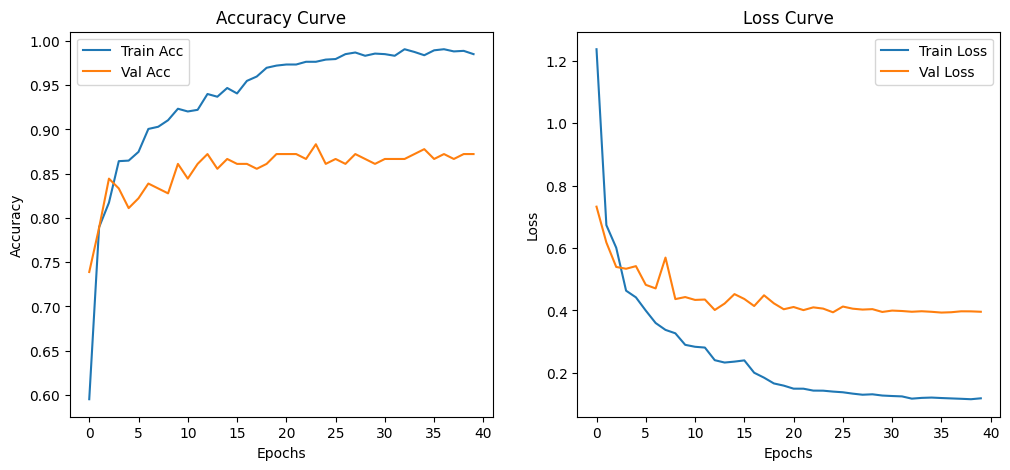


Test Classification Report:
               precision    recall  f1-score   support

         Aush     1.0000    1.0000    1.0000        20
        BR-28     0.7895    0.7500    0.7692        20
        BR-29     1.0000    0.8000    0.8889        20
        Beroi     1.0000    1.0000    1.0000        20
    Chinigura     0.9091    1.0000    0.9524        20
    Ghee Bhog     0.8947    0.8500    0.8718        20
 Katari Najir     0.8000    0.8000    0.8000        20
Katari Siddho     0.8500    0.8500    0.8500        20
      Miniket     0.8696    1.0000    0.9302        20
       Swarna     0.9524    1.0000    0.9756        20

     accuracy                         0.9050       200
    macro avg     0.9065    0.9050    0.9038       200
 weighted avg     0.9065    0.9050    0.9038       200



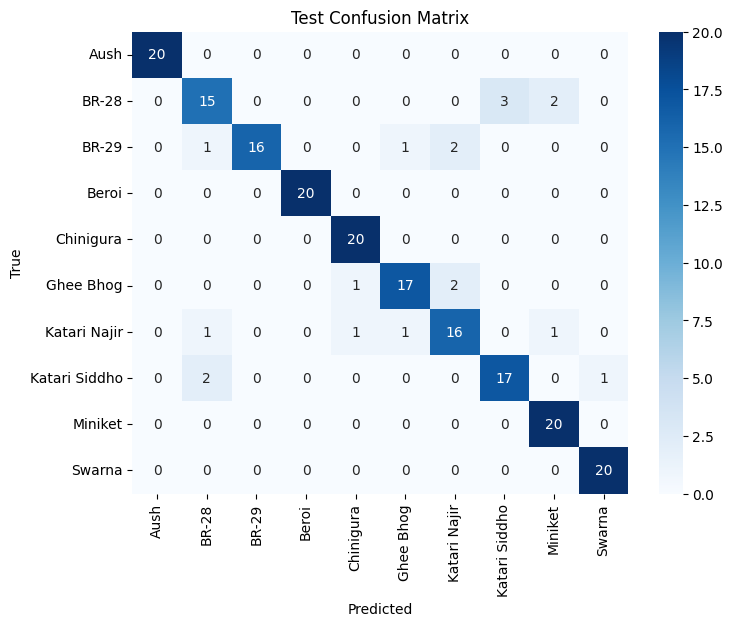

Aush Accuracy: 1.0000
BR-28 Accuracy: 0.7500
BR-29 Accuracy: 0.8000
Beroi Accuracy: 1.0000
Chinigura Accuracy: 1.0000
Ghee Bhog Accuracy: 0.8500
Katari Najir Accuracy: 0.8000
Katari Siddho Accuracy: 0.8500
Miniket Accuracy: 1.0000
Swarna Accuracy: 1.0000
Test AUC: 0.9924
Test PR AUC: 0.9564

Training Time: 725.62 seconds


In [9]:
import os
import time
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, confusion_matrix
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import NASNetMobile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# Paths and parameters
# -----------------------------
split_base_dir = '/kaggle/working/split_data'
dataset_dir = "/root/.cache/kagglehub/datasets/nuranfarhanaprova/processed-rice-varieties-of-bangladesh/versions/1/Original_Images"
img_size = (224, 224)
batch_size = 32
num_classes = 10
classes = sorted([d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))])

# -----------------------------
# Data generators
# -----------------------------
datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_directory(
    os.path.join(split_base_dir, 'train'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    os.path.join(split_base_dir, 'val'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_gen = datagen.flow_from_directory(
    os.path.join(split_base_dir, 'test'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# -----------------------------
# Model: NASNetMobile
# -----------------------------
def build_nasnetmobile_model(input_shape=(224,224,3), num_classes=10, dropout_rate=0.3, l2_reg=1e-4):
    base_model = NASNetMobile(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # freeze backbone
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(l2_reg))(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=outputs)
    return model

nasnet_model = build_nasnetmobile_model(num_classes=num_classes)
nasnet_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# -----------------------------
# Callback (Only ReduceLROnPlateau)
# -----------------------------
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# -----------------------------
# Training
# -----------------------------
start_time = time.time()
history = nasnet_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=40,
    callbacks=[reduce_lr],
    verbose=2
)
training_time = time.time() - start_time

# -----------------------------
# Plot training curves
# -----------------------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# -----------------------------
# Evaluation function
# -----------------------------
def evaluate_model(generator, model):
    steps = int(np.ceil(generator.samples / generator.batch_size))
    y_true = []
    y_pred_prob = []
    for _ in range(steps):
        x_batch, y_batch = next(generator)
        preds = model.predict(x_batch, verbose=0)
        y_true.append(y_batch)
        y_pred_prob.append(preds)
    y_true = np.vstack(y_true)
    y_pred_prob = np.vstack(y_pred_prob)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true_labels = np.argmax(y_true, axis=1)
    return y_true_labels, y_pred, y_true, y_pred_prob

train_true, train_pred, train_true_prob, train_pred_prob = evaluate_model(train_gen, nasnet_model)
val_true, val_pred, val_true_prob, val_pred_prob = evaluate_model(val_gen, nasnet_model)
test_true, test_pred, test_true_prob, test_pred_prob = evaluate_model(test_gen, nasnet_model)

# -----------------------------
# Reports
# -----------------------------
print("\nTest Classification Report:")
print(classification_report(test_true, test_pred, digits=4, target_names=classes))

cm = confusion_matrix(test_true, test_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Test Confusion Matrix')
plt.show()

# Per-class accuracy
per_class_acc = cm.diagonal() / cm.sum(axis=1)
for cls, acc in zip(classes, per_class_acc):
    print(f"{cls} Accuracy: {acc:.4f}")

# AUC & PR
print(f"Test AUC: {roc_auc_score(test_true_prob, test_pred_prob, average='macro', multi_class='ovr'):.4f}")
print(f"Test PR AUC: {average_precision_score(test_true_prob, test_pred_prob, average='macro'):.4f}")

print(f"\nTraining Time: {training_time:.2f} seconds")


In [10]:
start_test = time.time()
_ = nasnet_model.predict(test_gen, verbose=0)
inference_time = time.time() - start_test
samples = test_gen.samples
print(f"Inference Time per sample: {inference_time/samples:.6f} seconds")


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Inference Time per sample: 0.266198 seconds


In [11]:
# Calculate and print the number of parameters
total_params = nasnet_model.count_params()
trainable_params = sum([tf.keras.backend.count_params(w) for w in nasnet_model.trainable_weights])
non_trainable_params = sum([tf.keras.backend.count_params(w) for w in nasnet_model.non_trainable_weights])

print(f"Total Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")
print(f"Non-Trainable Parameters: {non_trainable_params:,}")

Total Parameters: 4,816,030
Trainable Parameters: 546,314
Non-Trainable Parameters: 4,269,716


Macro Precision: 0.9065
Macro Recall: 0.9050
Macro F1-score: 0.9038
Aush: Precision=1.0000, Recall=1.0000, F1=1.0000
BR-28: Precision=0.7895, Recall=0.7500, F1=0.7692
BR-29: Precision=1.0000, Recall=0.8000, F1=0.8889
Beroi: Precision=1.0000, Recall=1.0000, F1=1.0000
Chinigura: Precision=0.9091, Recall=1.0000, F1=0.9524
Ghee Bhog: Precision=0.8947, Recall=0.8500, F1=0.8718
Katari Najir: Precision=0.8000, Recall=0.8000, F1=0.8000
Katari Siddho: Precision=0.8500, Recall=0.8500, F1=0.8500
Miniket: Precision=0.8696, Recall=1.0000, F1=0.9302
Swarna: Precision=0.9524, Recall=1.0000, F1=0.9756


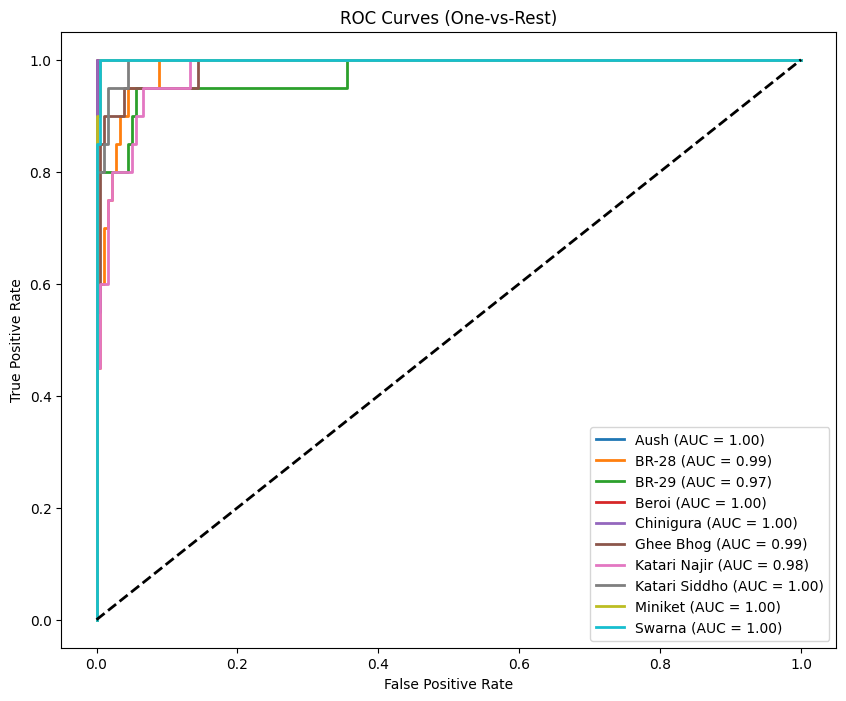

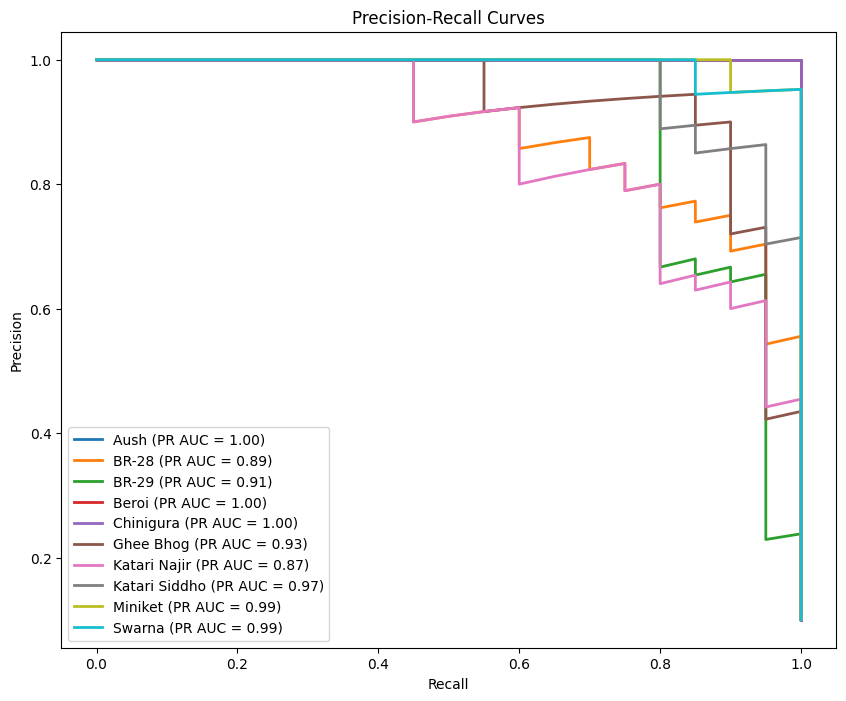

Total inference time: 4.13 sec
Inference time per sample: 0.020668 sec

Most confused class pairs:
Aush is most often confused with Aush (0 samples)
BR-28 is most often confused with Katari Siddho (3 samples)
BR-29 is most often confused with Katari Najir (2 samples)
Beroi is most often confused with Aush (0 samples)
Chinigura is most often confused with Aush (0 samples)
Ghee Bhog is most often confused with Katari Najir (2 samples)
Katari Najir is most often confused with BR-28 (1 samples)
Katari Siddho is most often confused with BR-28 (2 samples)
Miniket is most often confused with Aush (0 samples)
Swarna is most often confused with Aush (0 samples)


In [12]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc, average_precision_score, precision_recall_curve
from sklearn.preprocessing import label_binarize
import pandas as pd
import time
import matplotlib.pyplot as plt

# -----------------------------
# Precision, Recall, F1-score
# -----------------------------
macro_precision = precision_score(test_true, test_pred, average='macro')
macro_recall = recall_score(test_true, test_pred, average='macro')
macro_f1 = f1_score(test_true, test_pred, average='macro')

print(f"Macro Precision: {macro_precision:.4f}")
print(f"Macro Recall: {macro_recall:.4f}")
print(f"Macro F1-score: {macro_f1:.4f}")

# Per-class scores
per_class_precision = precision_score(test_true, test_pred, average=None)
per_class_recall = recall_score(test_true, test_pred, average=None)
per_class_f1 = f1_score(test_true, test_pred, average=None)

for i, cls in enumerate(classes):
    print(f"{cls}: Precision={per_class_precision[i]:.4f}, Recall={per_class_recall[i]:.4f}, F1={per_class_f1[i]:.4f}")

# -----------------------------
# ROC–AUC curves (One-vs-Rest)
# -----------------------------
y_true_bin = label_binarize(test_true, classes=range(num_classes))

plt.figure(figsize=(10,8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], test_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{classes[i]} (AUC = {roc_auc:.2f})')

plt.plot([0,1],[0,1],'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (One-vs-Rest)')
plt.legend(loc='lower right')
plt.show()

# -----------------------------
# PR curves
# -----------------------------
plt.figure(figsize=(10,8))
for i in range(num_classes):
    precision_vals, recall_vals, _ = precision_recall_curve(y_true_bin[:, i], test_pred_prob[:, i])
    pr_auc = auc(recall_vals, precision_vals)
    plt.plot(recall_vals, precision_vals, lw=2, label=f'{classes[i]} (PR AUC = {pr_auc:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc='lower left')
plt.show()

# -----------------------------
# Testing / Inference time per sample
# -----------------------------
start_infer = time.time()
_ = nasnet_model.predict(test_gen, verbose=0)
total_infer_time = time.time() - start_infer
time_per_sample = total_infer_time / test_gen.samples
print(f"Total inference time: {total_infer_time:.2f} sec")
print(f"Inference time per sample: {time_per_sample:.6f} sec")

# -----------------------------
# Failure modes: most confused class pairs
# -----------------------------
cm_df = pd.DataFrame(confusion_matrix(test_true, test_pred), index=classes, columns=classes)

print("\nMost confused class pairs:")
for cls in classes:
    row = cm_df.loc[cls].copy()
    row[cls] = 0  # ignore correct predictions
    most_confused = row.idxmax()
    print(f"{cls} is most often confused with {most_confused} ({row.max()} samples)")

Found 1620 images belonging to 10 classes.
Found 180 images belonging to 10 classes.
Found 200 images belonging to 10 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
51/51 - 46s - 899ms/step - accuracy: 0.2864 - loss: 2.0472 - val_accuracy: 0.5333 - val_loss: 1.4966 - learning_rate: 1.0000e-03
Epoch 2/40
51/51 - 15s - 298ms/step - accuracy: 0.5148 - loss: 1.3955 - val_accuracy: 0.5389 - val_loss: 1.2951 - learning_rate: 1.0000e-03
Epoch 3/40
51/51 - 17s - 324ms/step - accuracy: 0.5796 - loss: 1.2108 - val_accuracy: 0.6333 - val_loss: 1.1204 - learning_rate: 1.0000e-03
Epoch 4/40
51/51 - 16s - 305ms/step - accuracy: 0.6432 - loss: 1.0740 - val_accuracy: 0.6444 - val_loss: 1.0158 - learning_rate: 1.0000e-03
Epoch 5/40
51/51 - 16s - 309ms/step - accuracy: 0.6426 - loss: 1.0227 - val_accuracy: 0.6944 - val_loss: 0.9748 - learning_rate: 1.0000e-03
Epoch 6/40
51/51 - 15s - 298ms/step - accuracy: 0.6864 - loss: 0.9650 - val_accuracy: 0.7000 - val_loss: 0.9685 - learning_rate: 1.0000e-03
Epoch 7/40
51/51 - 16s - 310ms/step - accuracy: 0.7080 - loss: 0.9094 - val_accuracy: 0.7222 - val_loss: 0.8814 - learning_rate: 1.0000e-03
Epoch 8/40
51/51 - 1

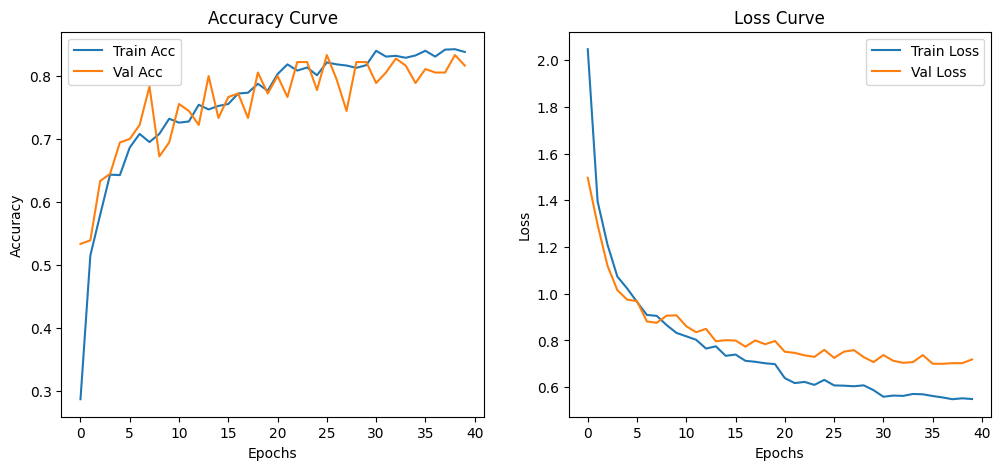


Test Classification Report:
               precision    recall  f1-score   support

         Aush     1.0000    0.8000    0.8889        20
        BR-28     0.8462    0.5500    0.6667        20
        BR-29     0.3929    0.5500    0.4583        20
        Beroi     0.7917    0.9500    0.8636        20
    Chinigura     0.9444    0.8500    0.8947        20
    Ghee Bhog     0.8667    0.6500    0.7429        20
 Katari Najir     0.5600    0.7000    0.6222        20
Katari Siddho     0.8421    0.8000    0.8205        20
      Miniket     0.9048    0.9500    0.9268        20
       Swarna     0.9524    1.0000    0.9756        20

     accuracy                         0.7800       200
    macro avg     0.8101    0.7800    0.7860       200
 weighted avg     0.8101    0.7800    0.7860       200



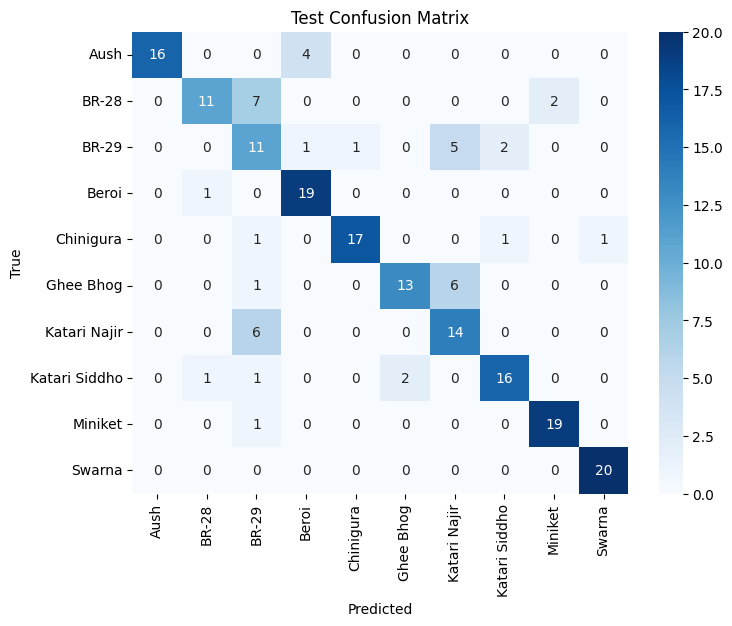

Aush Accuracy: 0.8000
BR-28 Accuracy: 0.5500
BR-29 Accuracy: 0.5500
Beroi Accuracy: 0.9500
Chinigura Accuracy: 0.8500
Ghee Bhog Accuracy: 0.6500
Katari Najir Accuracy: 0.7000
Katari Siddho Accuracy: 0.8000
Miniket Accuracy: 0.9500
Swarna Accuracy: 1.0000
Test AUC: 0.9736
Test PR AUC: 0.8713

Training Time: 656.51 seconds


In [5]:
import os
import time
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, confusion_matrix
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import ConvNeXtTiny
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# Paths and parameters
# -----------------------------
split_base_dir = '/kaggle/working/split_data'
dataset_dir = "/root/.cache/kagglehub/datasets/nuranfarhanaprova/processed-rice-varieties-of-bangladesh/versions/1/Original_Images"
img_size = (224, 224)
batch_size = 32
num_classes = 10
classes = sorted([d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))])

# -----------------------------
# Data generators
# -----------------------------
datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_directory(
    os.path.join(split_base_dir, 'train'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    os.path.join(split_base_dir, 'val'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_gen = datagen.flow_from_directory(
    os.path.join(split_base_dir, 'test'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# -----------------------------
# Model: ConvNeXtTiny
# -----------------------------
def build_convnext_model(input_shape=(224,224,3), num_classes=10, dropout_rate=0.3, l2_reg=1e-4):
    base_model = ConvNeXtTiny(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # freeze backbone
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(l2_reg))(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=outputs)
    return model

convnext_model = build_convnext_model(num_classes=num_classes)
convnext_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# -----------------------------
# Callback: Reduce LR only
# -----------------------------
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# -----------------------------
# Training
# -----------------------------
start_time = time.time()
history = convnext_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=40,
    callbacks=[reduce_lr],
    verbose=2
)
training_time = time.time() - start_time

# -----------------------------
# Plot training curves
# -----------------------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# -----------------------------
# Evaluation function
# -----------------------------
def evaluate_model(generator, model):
    steps = int(np.ceil(generator.samples / generator.batch_size))
    y_true = []
    y_pred_prob = []
    for _ in range(steps):
        x_batch, y_batch = next(generator)
        preds = model.predict(x_batch, verbose=0)
        y_true.append(y_batch)
        y_pred_prob.append(preds)
    y_true = np.vstack(y_true)
    y_pred_prob = np.vstack(y_pred_prob)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true_labels = np.argmax(y_true, axis=1)
    return y_true_labels, y_pred, y_true, y_pred_prob

train_true, train_pred, train_true_prob, train_pred_prob = evaluate_model(train_gen, convnext_model)
val_true, val_pred, val_true_prob, val_pred_prob = evaluate_model(val_gen, convnext_model)
test_true, test_pred, test_true_prob, test_pred_prob = evaluate_model(test_gen, convnext_model)

# -----------------------------
# Reports
# -----------------------------
print("\nTest Classification Report:")
print(classification_report(test_true, test_pred, digits=4, target_names=classes))

cm = confusion_matrix(test_true, test_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Test Confusion Matrix')
plt.show()

# Per-class accuracy
per_class_acc = cm.diagonal() / cm.sum(axis=1)
for cls, acc in zip(classes, per_class_acc):
    print(f"{cls} Accuracy: {acc:.4f}")

# AUC & PR
print(f"Test AUC: {roc_auc_score(test_true_prob, test_pred_prob, average='macro', multi_class='ovr'):.4f}")
print(f"Test PR AUC: {average_precision_score(test_true_prob, test_pred_prob, average='macro'):.4f}")

print(f"\nTraining Time: {training_time:.2f} seconds")


In [7]:
start_test = time.time()
_ = convnext_model.predict(test_gen, verbose=0)
inference_time = time.time() - start_test
samples = test_gen.samples
print(f"Inference Time per sample: {inference_time/samples:.6f} seconds")

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Inference Time per sample: 0.054343 seconds


In [8]:
# Calculate and print the number of parameters
total_params = convnext_model.count_params()
trainable_params = sum([tf.keras.backend.count_params(w) for w in convnext_model.trainable_weights])
non_trainable_params = sum([tf.keras.backend.count_params(w) for w in convnext_model.non_trainable_weights])

print(f"Total Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")
print(f"Non-Trainable Parameters: {non_trainable_params:,}")

Total Parameters: 28,218,986
Trainable Parameters: 398,858
Non-Trainable Parameters: 27,820,128


Macro Precision: 0.9065
Macro Recall: 0.9050
Macro F1-score: 0.9038
Aush: Precision=1.0000, Recall=1.0000, F1=1.0000
BR-28: Precision=0.7895, Recall=0.7500, F1=0.7692
BR-29: Precision=1.0000, Recall=0.8000, F1=0.8889
Beroi: Precision=1.0000, Recall=1.0000, F1=1.0000
Chinigura: Precision=0.9091, Recall=1.0000, F1=0.9524
Ghee Bhog: Precision=0.8947, Recall=0.8500, F1=0.8718
Katari Najir: Precision=0.8000, Recall=0.8000, F1=0.8000
Katari Siddho: Precision=0.8500, Recall=0.8500, F1=0.8500
Miniket: Precision=0.8696, Recall=1.0000, F1=0.9302
Swarna: Precision=0.9524, Recall=1.0000, F1=0.9756


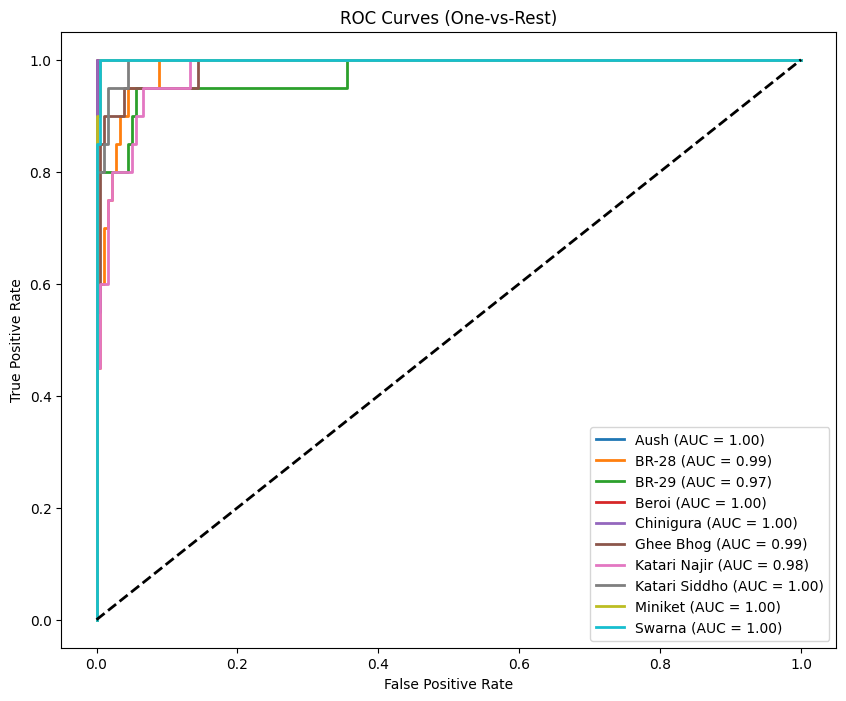

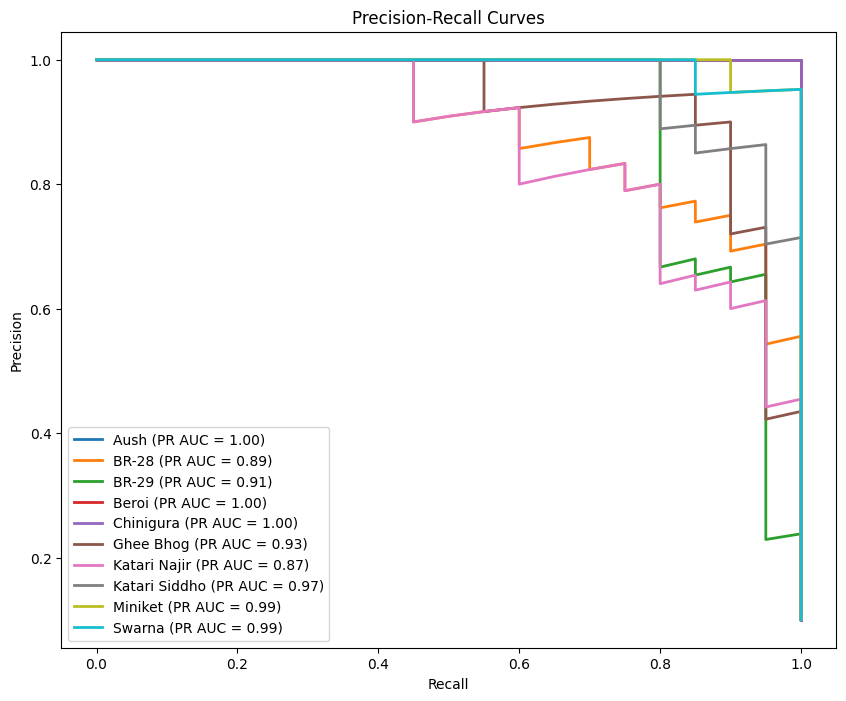

Total inference time: 3.01 sec
Inference time per sample: 0.015041 sec

Most confused class pairs:
Aush is most often confused with Aush (0 samples)
BR-28 is most often confused with Katari Siddho (3 samples)
BR-29 is most often confused with Katari Najir (2 samples)
Beroi is most often confused with Aush (0 samples)
Chinigura is most often confused with Aush (0 samples)
Ghee Bhog is most often confused with Katari Najir (2 samples)
Katari Najir is most often confused with BR-28 (1 samples)
Katari Siddho is most often confused with BR-28 (2 samples)
Miniket is most often confused with Aush (0 samples)
Swarna is most often confused with Aush (0 samples)


In [13]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc, average_precision_score, precision_recall_curve
from sklearn.preprocessing import label_binarize
import pandas as pd
import time
import matplotlib.pyplot as plt

# -----------------------------
# Precision, Recall, F1-score
# -----------------------------
macro_precision = precision_score(test_true, test_pred, average='macro')
macro_recall = recall_score(test_true, test_pred, average='macro')
macro_f1 = f1_score(test_true, test_pred, average='macro')

print(f"Macro Precision: {macro_precision:.4f}")
print(f"Macro Recall: {macro_recall:.4f}")
print(f"Macro F1-score: {macro_f1:.4f}")

# Per-class scores
per_class_precision = precision_score(test_true, test_pred, average=None)
per_class_recall = recall_score(test_true, test_pred, average=None)
per_class_f1 = f1_score(test_true, test_pred, average=None)

for i, cls in enumerate(classes):
    print(f"{cls}: Precision={per_class_precision[i]:.4f}, Recall={per_class_recall[i]:.4f}, F1={per_class_f1[i]:.4f}")

# -----------------------------
# ROC–AUC curves (One-vs-Rest)
# -----------------------------
y_true_bin = label_binarize(test_true, classes=range(num_classes))

plt.figure(figsize=(10,8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], test_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{classes[i]} (AUC = {roc_auc:.2f})')

plt.plot([0,1],[0,1],'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (One-vs-Rest)')
plt.legend(loc='lower right')
plt.show()

# -----------------------------
# PR curves
# -----------------------------
plt.figure(figsize=(10,8))
for i in range(num_classes):
    precision_vals, recall_vals, _ = precision_recall_curve(y_true_bin[:, i], test_pred_prob[:, i])
    pr_auc = auc(recall_vals, precision_vals)
    plt.plot(recall_vals, precision_vals, lw=2, label=f'{classes[i]} (PR AUC = {pr_auc:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc='lower left')
plt.show()

# -----------------------------
# Testing / Inference time per sample
# -----------------------------
start_infer = time.time()
_ = convnext_model.predict(test_gen, verbose=0)
total_infer_time = time.time() - start_infer
time_per_sample = total_infer_time / test_gen.samples
print(f"Total inference time: {total_infer_time:.2f} sec")
print(f"Inference time per sample: {time_per_sample:.6f} sec")

# -----------------------------
# Failure modes: most confused class pairs
# -----------------------------
cm_df = pd.DataFrame(confusion_matrix(test_true, test_pred), index=classes, columns=classes)

print("\nMost confused class pairs:")
for cls in classes:
    row = cm_df.loc[cls].copy()
    row[cls] = 0  # ignore correct predictions
    most_confused = row.idxmax()
    print(f"{cls} is most often confused with {most_confused} ({row.max()} samples)")

Found 1620 images belonging to 10 classes.
Found 180 images belonging to 10 classes.
Found 200 images belonging to 10 classes.
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
51/51 - 61s - 1s/step - accuracy: 0.6148 - loss: 1.1887 - val_accuracy: 0.7833 - val_loss: 0.6594 - learning_rate: 1.0000e-03
Epoch 2/40
51/51 - 17s - 338ms/step - accuracy: 0.8253 - loss: 0.5751 - val_accuracy: 0.8611 - val_loss: 0.5132 - learning_rate: 1.0000e-03
Epoch 3/40
51/51 - 17s - 340ms/step - accuracy: 0.8506 - loss: 0.4901 - val_accuracy: 0.8611 - val_loss: 0.4656 - learning_rate: 1.0000e-03
Epoch 4/40
51/51 - 18s - 354ms/step - accuracy: 0.8901 - loss: 0.3734 - val_accuracy: 0.8667 - val_loss: 0.4708 - learning_rate: 1.0000e-03
Epoch 5/40
51/51 - 17s - 339ms/step - accuracy: 0.8994 - loss: 0.3568 - val_accuracy: 0.8500 - val_loss: 0.4261 - learning_rate: 1.0000e-03
Epoch 6/40
51/51 - 17s - 342ms/step - accuracy: 0.9210 - loss: 0.2995 - val_accuracy: 0.8889 - val_loss: 0.4502 - learning_rate: 1.0000e-03
Epoch 7/40
51/51 - 17s - 337ms/step - accuracy: 0.9309 - loss: 0.2655 - val_accuracy: 0.8833 - val_loss: 0.4032 - learning_rate: 1.0000e-03
Epoch 8/40
51/51 - 18s 

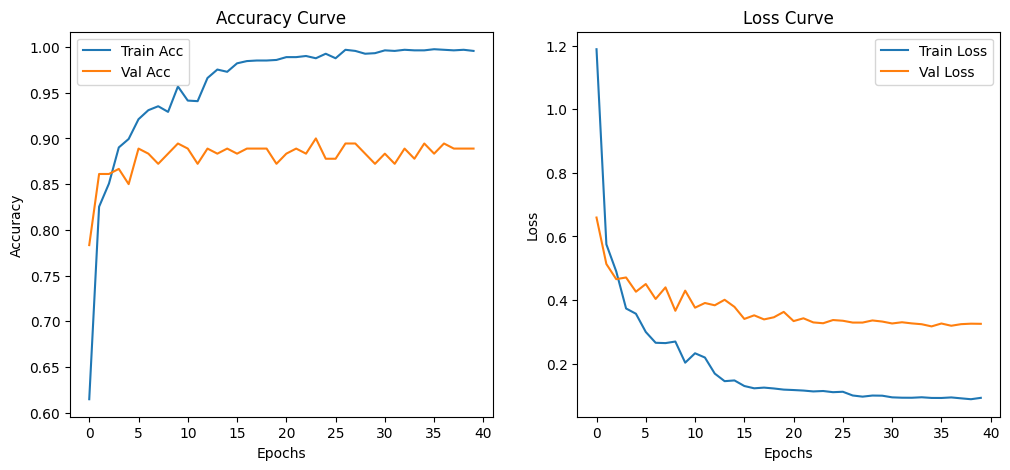


Test Classification Report:
               precision    recall  f1-score   support

         Aush     1.0000    1.0000    1.0000        20
        BR-28     0.8636    0.9500    0.9048        20
        BR-29     0.9048    0.9500    0.9268        20
        Beroi     1.0000    1.0000    1.0000        20
    Chinigura     1.0000    0.9500    0.9744        20
    Ghee Bhog     0.8696    1.0000    0.9302        20
 Katari Najir     0.8824    0.7500    0.8108        20
Katari Siddho     1.0000    0.8500    0.9189        20
      Miniket     0.9091    1.0000    0.9524        20
       Swarna     0.8947    0.8500    0.8718        20

     accuracy                         0.9300       200
    macro avg     0.9324    0.9300    0.9290       200
 weighted avg     0.9324    0.9300    0.9290       200



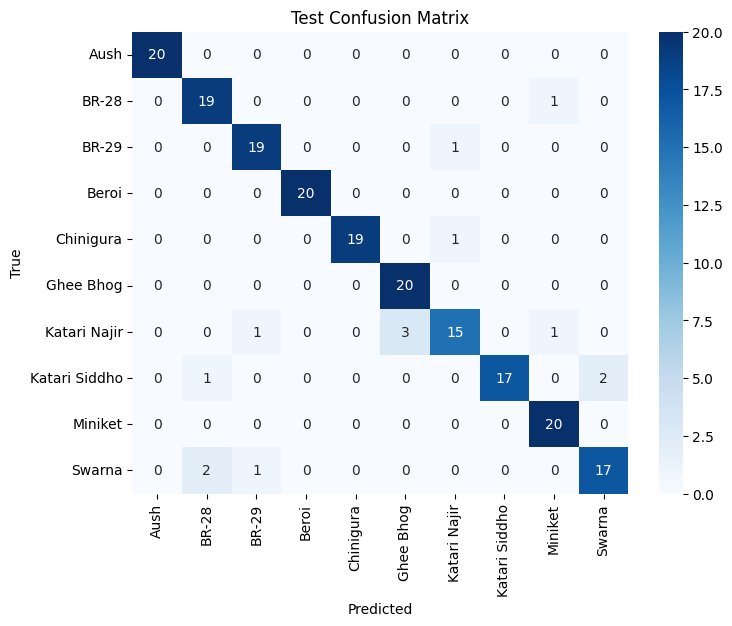

Aush Accuracy: 1.0000
BR-28 Accuracy: 0.9500
BR-29 Accuracy: 0.9500
Beroi Accuracy: 1.0000
Chinigura Accuracy: 0.9500
Ghee Bhog Accuracy: 1.0000
Katari Najir Accuracy: 0.7500
Katari Siddho Accuracy: 0.8500
Miniket Accuracy: 1.0000
Swarna Accuracy: 0.8500
Macro Precision: 0.9324
Macro Recall: 0.9300
Macro F1-score: 0.9290
Aush: Precision=1.0000, Recall=1.0000, F1=1.0000
BR-28: Precision=0.8636, Recall=0.9500, F1=0.9048
BR-29: Precision=0.9048, Recall=0.9500, F1=0.9268
Beroi: Precision=1.0000, Recall=1.0000, F1=1.0000
Chinigura: Precision=1.0000, Recall=0.9500, F1=0.9744
Ghee Bhog: Precision=0.8696, Recall=1.0000, F1=0.9302
Katari Najir: Precision=0.8824, Recall=0.7500, F1=0.8108
Katari Siddho: Precision=1.0000, Recall=0.8500, F1=0.9189
Miniket: Precision=0.9091, Recall=1.0000, F1=0.9524
Swarna: Precision=0.8947, Recall=0.8500, F1=0.8718


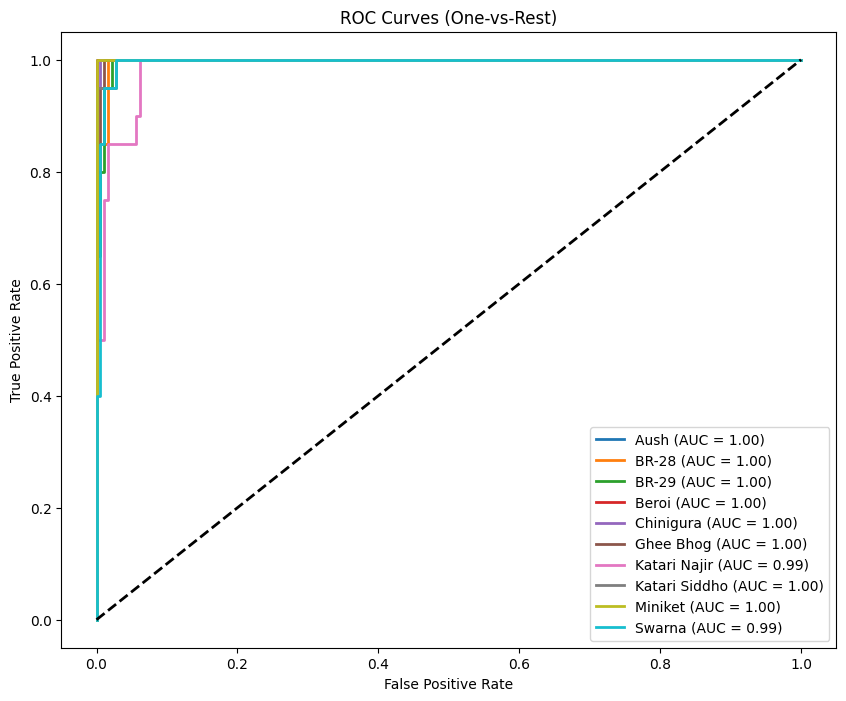

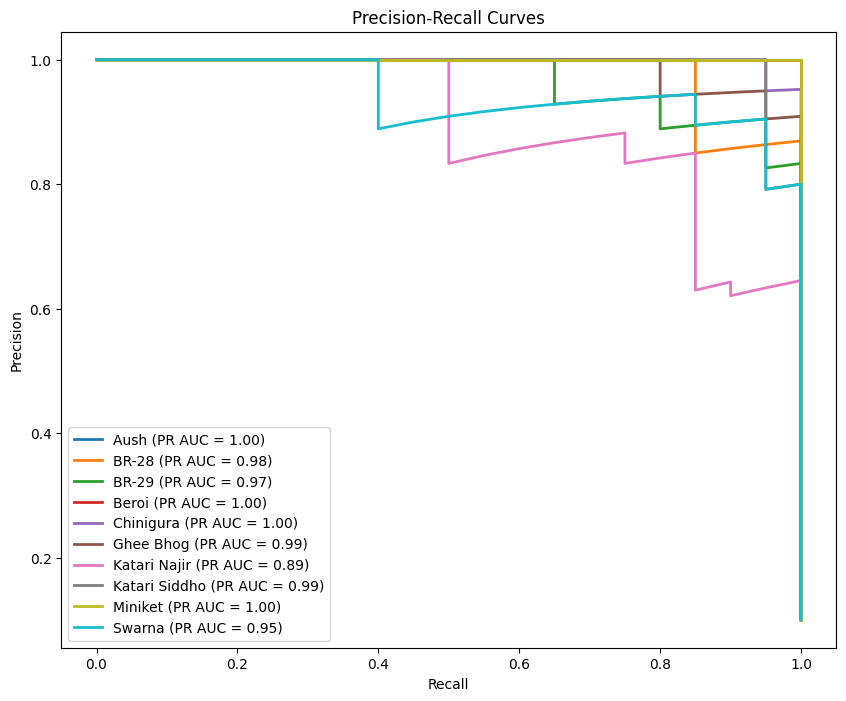

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Total inference time: 15.88 sec
Inference time per sample: 0.079375 sec

Most confused class pairs:
Aush is most often confused with Aush (0 samples)
BR-28 is most often confused with Miniket (1 samples)
BR-29 is most often confused with Katari Najir (1 samples)
Beroi is most often confused with Aush (0 samples)
Chinigura is most often confused with Katari Najir (1 samples)
Ghee Bhog is most often confused with Aush (0 samples)
Katari Najir is most often confused with Ghee Bhog (3 samples)
Katari Siddho is most often confused with Swarna (2 samples)
Miniket is most often confused with Aush (0 samples)
Swarna is most often confused with BR-28 (2 samples)


In [14]:
import os
import time
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import label_binarize
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
import seaborn as sns

# -----------------------------
# Paths and parameters
# -----------------------------
split_base_dir = '/kaggle/working/split_data'
dataset_dir = "/root/.cache/kagglehub/datasets/nuranfarhanaprova/processed-rice-varieties-of-bangladesh/versions/1/Original_Images"
img_size = (299, 299)  # InceptionV3 default input
batch_size = 32
num_classes = 10
classes = sorted([d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))])

# -----------------------------
# Data generators
# -----------------------------
datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_directory(
    os.path.join(split_base_dir, 'train'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    os.path.join(split_base_dir, 'val'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_gen = datagen.flow_from_directory(
    os.path.join(split_base_dir, 'test'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# -----------------------------
# Model: InceptionV3
# -----------------------------
def build_inception_model(input_shape=(299,299,3), num_classes=10, dropout_rate=0.3, l2_reg=1e-4):
    base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # freeze backbone
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(l2_reg))(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=outputs)
    return model

inception_model = build_inception_model(num_classes=num_classes)
inception_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# -----------------------------
# Callback (no early stop)
# -----------------------------
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# -----------------------------
# Training
# -----------------------------
start_time = time.time()
history = inception_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=40,
    callbacks=[reduce_lr],
    verbose=2
)
training_time = time.time() - start_time

# -----------------------------
# Plot training curves
# -----------------------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# -----------------------------
# Evaluation function
# -----------------------------
def evaluate_model(generator, model):
    steps = int(np.ceil(generator.samples / generator.batch_size))
    y_true, y_pred_prob = [], []
    for _ in range(steps):
        x_batch, y_batch = next(generator)
        preds = model.predict(x_batch, verbose=0)
        y_true.append(y_batch)
        y_pred_prob.append(preds)
    y_true = np.vstack(y_true)
    y_pred_prob = np.vstack(y_pred_prob)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true_labels = np.argmax(y_true, axis=1)
    return y_true_labels, y_pred, y_true, y_pred_prob

train_true, train_pred, train_true_prob, train_pred_prob = evaluate_model(train_gen, inception_model)
val_true, val_pred, val_true_prob, val_pred_prob = evaluate_model(val_gen, inception_model)
test_true, test_pred, test_true_prob, test_pred_prob = evaluate_model(test_gen, inception_model)

# -----------------------------
# Reports
# -----------------------------
print("\nTest Classification Report:")
print(classification_report(test_true, test_pred, digits=4, target_names=classes))

cm = confusion_matrix(test_true, test_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Test Confusion Matrix')
plt.show()

# Per-class accuracy
per_class_acc = cm.diagonal() / cm.sum(axis=1)
for cls, acc in zip(classes, per_class_acc):
    print(f"{cls} Accuracy: {acc:.4f}")

# -----------------------------
# Precision, Recall, F1-score
# -----------------------------
macro_precision = precision_score(test_true, test_pred, average='macro')
macro_recall = recall_score(test_true, test_pred, average='macro')
macro_f1 = f1_score(test_true, test_pred, average='macro')

print(f"Macro Precision: {macro_precision:.4f}")
print(f"Macro Recall: {macro_recall:.4f}")
print(f"Macro F1-score: {macro_f1:.4f}")

per_class_precision = precision_score(test_true, test_pred, average=None)
per_class_recall = recall_score(test_true, test_pred, average=None)
per_class_f1 = f1_score(test_true, test_pred, average=None)

for i, cls in enumerate(classes):
    print(f"{cls}: Precision={per_class_precision[i]:.4f}, Recall={per_class_recall[i]:.4f}, F1={per_class_f1[i]:.4f}")

# -----------------------------
# ROC–AUC curves (One-vs-Rest)
# -----------------------------
y_true_bin = label_binarize(test_true, classes=range(num_classes))

plt.figure(figsize=(10,8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], test_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{classes[i]} (AUC = {roc_auc:.2f})')

plt.plot([0,1],[0,1],'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (One-vs-Rest)')
plt.legend(loc='lower right')
plt.show()

# -----------------------------
# PR curves
# -----------------------------
plt.figure(figsize=(10,8))
for i in range(num_classes):
    precision_vals, recall_vals, _ = precision_recall_curve(y_true_bin[:, i], test_pred_prob[:, i])
    pr_auc = auc(recall_vals, precision_vals)
    plt.plot(recall_vals, precision_vals, lw=2, label=f'{classes[i]} (PR AUC = {pr_auc:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc='lower left')
plt.show()

# -----------------------------
# Testing / Inference time per sample
# -----------------------------
start_infer = time.time()
_ = inception_model.predict(test_gen, verbose=0)
total_infer_time = time.time() - start_infer
time_per_sample = total_infer_time / test_gen.samples
print(f"Total inference time: {total_infer_time:.2f} sec")
print(f"Inference time per sample: {time_per_sample:.6f} sec")

# -----------------------------
# Failure modes: most confused class pairs
# -----------------------------
cm_df = pd.DataFrame(confusion_matrix(test_true, test_pred), index=classes, columns=classes)

print("\nMost confused class pairs:")
for cls in classes:
    row = cm_df.loc[cls].copy()
    row[cls] = 0
    most_confused = row.idxmax()
    print(f"{cls} is most often confused with {most_confused} ({row.max()} samples)")


In [15]:
start_test = time.time()
_ = inception_model.predict(test_gen, verbose=0)
inference_time = time.time() - start_test
samples = test_gen.samples
print(f"Inference Time per sample: {inference_time/samples:.6f} seconds")

Inference Time per sample: 0.012600 seconds


In [16]:
# Calculate and print the number of parameters
total_params = inception_model.count_params()
trainable_params = sum([tf.keras.backend.count_params(w) for w in inception_model.trainable_weights]) # Corrected to use inception_model weights
non_trainable_params = sum([tf.keras.backend.count_params(w) for w in inception_model.non_trainable_weights]) # Corrected to use inception_model weights

print(f"Total Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")
print(f"Non-Trainable Parameters: {non_trainable_params:,}")

Total Parameters: 22,857,002
Trainable Parameters: 1,054,218
Non-Trainable Parameters: 21,802,784


Found 1620 images belonging to 10 classes.
Found 180 images belonging to 10 classes.
Found 200 images belonging to 10 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
51/51 - 44s - 855ms/step - accuracy: 0.2444 - loss: 2.1743 - val_accuracy: 0.4111 - val_loss: 1.7742 - learning_rate: 1.0000e-03
Epoch 2/40
51/51 - 15s - 297ms/step - accuracy: 0.3654 - loss: 1.7150 - val_accuracy: 0.4333 - val_loss: 1.5603 - learning_rate: 1.0000e-03
Epoch 3/40
51/51 - 16s - 313ms/step - accuracy: 0.4204 - loss: 1.5477 - val_accuracy: 0.5278 - val_loss: 1.4634 - learning_rate: 1.0000e-03
Epoch 4/40
51/51 - 15s - 294ms/step - accuracy: 0.4759 - loss: 1.4380 - val_accuracy: 0.4722 - val_loss: 1.3838 - learning_rate: 1.0000e-03
Epoch 5/40
51/51 - 16s - 314ms/step - accuracy: 0.5142 - loss: 1.3530 - val_accuracy: 0.5500 - val_loss: 1.3585 - learning_rate: 1.0000e-03
Epoch 6/40
51/51 - 15s - 296ms/step - accuracy: 0.5210 - loss: 1.3226 - val_accuracy: 0.5500 - val_loss: 1.2095 - learning_rate: 1.0000e-03
Epoch 7/40
51/51 - 15s - 296ms/step - accuracy: 0.5500 - loss: 1.2656 - val_accuracy: 0.5778 - val_loss: 1.2267 - learning_rate: 1.0000e-03
Epoch 8/40
51/51 - 1

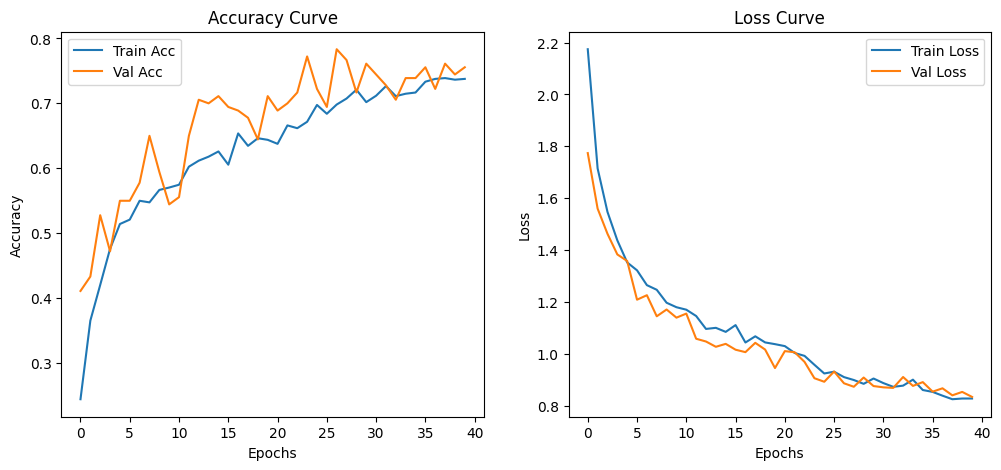


Test Classification Report:
               precision    recall  f1-score   support

         Aush     1.0000    0.7500    0.8571        20
        BR-28     0.6818    0.7500    0.7143        20
        BR-29     0.6000    0.3000    0.4000        20
        Beroi     0.6429    0.9000    0.7500        20
    Chinigura     0.7500    0.7500    0.7500        20
    Ghee Bhog     0.6500    0.6500    0.6500        20
 Katari Najir     0.3810    0.4000    0.3902        20
Katari Siddho     0.8235    0.7000    0.7568        20
      Miniket     0.7692    1.0000    0.8696        20
       Swarna     0.7619    0.8000    0.7805        20

     accuracy                         0.7000       200
    macro avg     0.7060    0.7000    0.6918       200
 weighted avg     0.7060    0.7000    0.6918       200



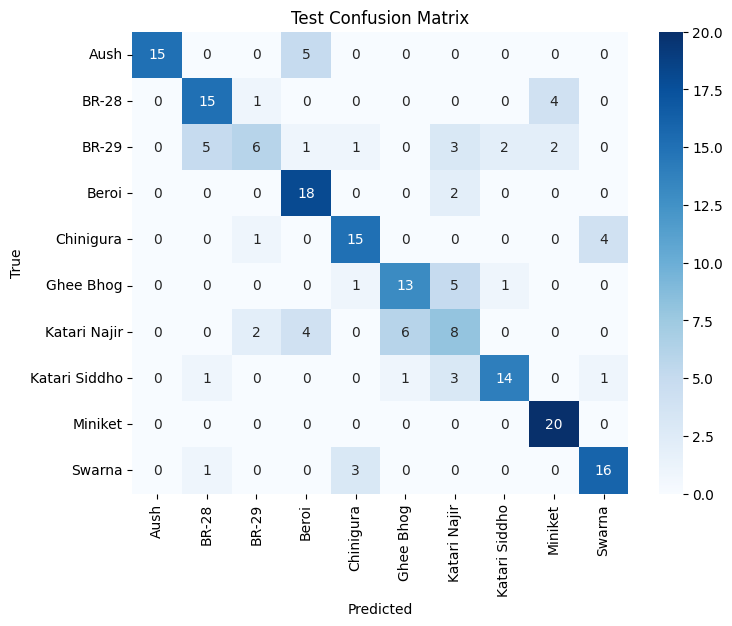

Aush Accuracy: 0.7500
BR-28 Accuracy: 0.7500
BR-29 Accuracy: 0.3000
Beroi Accuracy: 0.9000
Chinigura Accuracy: 0.7500
Ghee Bhog Accuracy: 0.6500
Katari Najir Accuracy: 0.4000
Katari Siddho Accuracy: 0.7000
Miniket Accuracy: 1.0000
Swarna Accuracy: 0.8000
Macro Precision: 0.7060
Macro Recall: 0.7000
Macro F1-score: 0.6918
Aush: Precision=1.0000, Recall=0.7500, F1=0.8571
BR-28: Precision=0.6818, Recall=0.7500, F1=0.7143
BR-29: Precision=0.6000, Recall=0.3000, F1=0.4000
Beroi: Precision=0.6429, Recall=0.9000, F1=0.7500
Chinigura: Precision=0.7500, Recall=0.7500, F1=0.7500
Ghee Bhog: Precision=0.6500, Recall=0.6500, F1=0.6500
Katari Najir: Precision=0.3810, Recall=0.4000, F1=0.3902
Katari Siddho: Precision=0.8235, Recall=0.7000, F1=0.7568
Miniket: Precision=0.7692, Recall=1.0000, F1=0.8696
Swarna: Precision=0.7619, Recall=0.8000, F1=0.7805


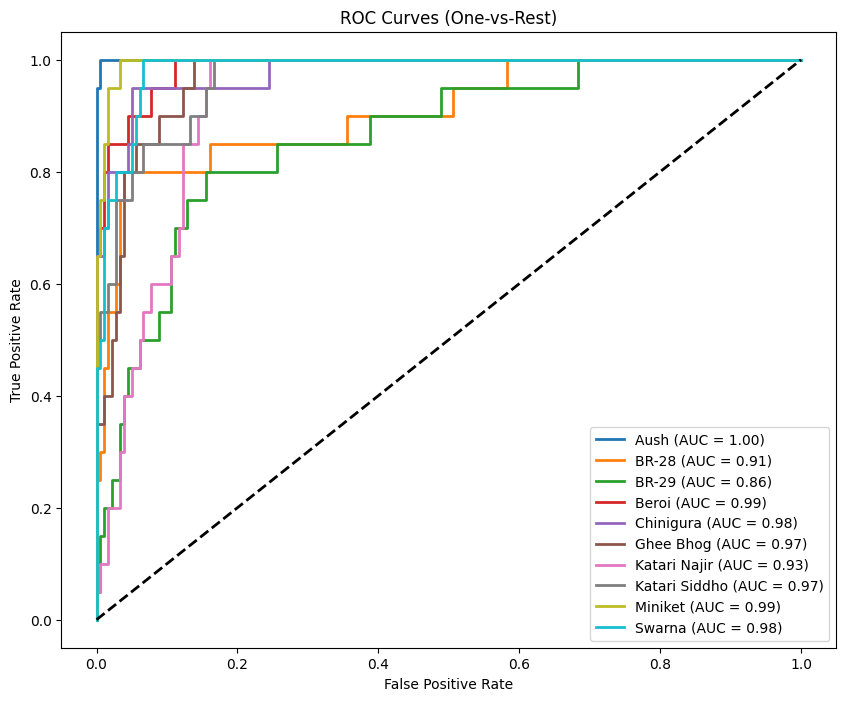

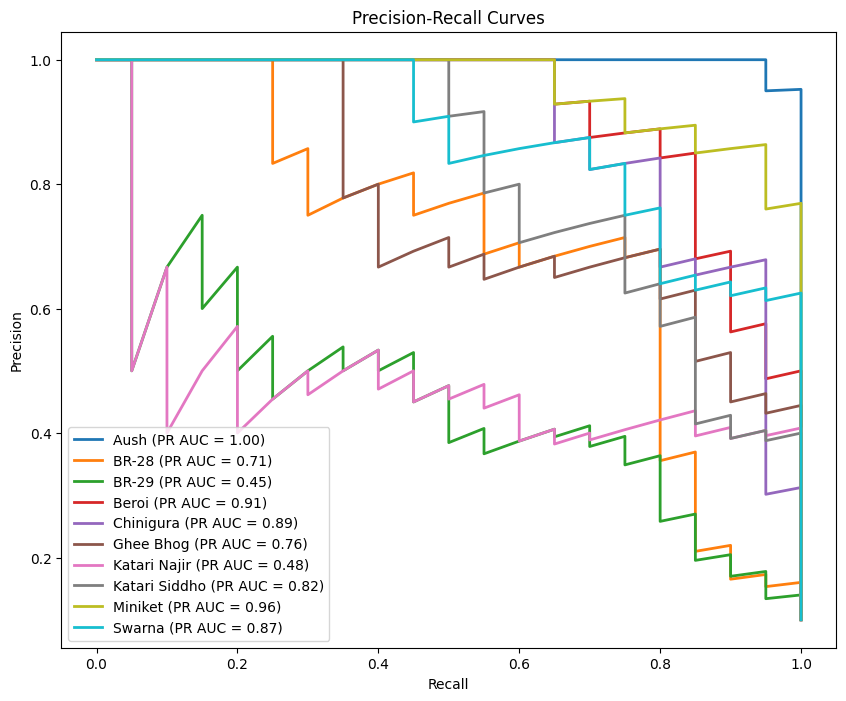

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Total inference time: 10.13 sec
Inference time per sample: 0.050653 sec

Most confused class pairs:
Aush is most often confused with Beroi (5 samples)
BR-28 is most often confused with Miniket (4 samples)
BR-29 is most often confused with BR-28 (5 samples)
Beroi is most often confused with Katari Najir (2 samples)
Chinigura is most often confused with Swarna (4 samples)
Ghee Bhog is most often confused with Katari Najir (5 samples)
Katari Najir is most often confused with Ghee Bhog (6 samples)
Katari Siddho is most often confused with Katari Najir (3 samples)
Miniket is most often confused with Aush (0 samples)
Swarna is most often confused with Chinigura (3 samples)


In [17]:
import os
import time
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import label_binarize
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

# -----------------------------
# Paths and parameters
# -----------------------------
split_base_dir = '/kaggle/working/split_data'
dataset_dir = "/root/.cache/kagglehub/datasets/nuranfarhanaprova/processed-rice-varieties-of-bangladesh/versions/1/Original_Images"
img_size = (224, 224)  # ResNet50 default input
batch_size = 32
num_classes = 10
classes = sorted([d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))])  # Sorted classes

# -----------------------------
# Data generators
# -----------------------------
datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_directory(
    os.path.join(split_base_dir, 'train'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    os.path.join(split_base_dir, 'val'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_gen = datagen.flow_from_directory(
    os.path.join(split_base_dir, 'test'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# -----------------------------
# Model: ResNet50
# -----------------------------
def build_resnet_model(input_shape=(224,224,3), num_classes=10, dropout_rate=0.3, l2_reg=1e-4):
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # freeze backbone
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(l2_reg))(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=outputs)
    return model

resnet_model = build_resnet_model(num_classes=num_classes)
resnet_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# -----------------------------
# Callbacks
# -----------------------------
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# -----------------------------
# Training
# -----------------------------
start_time = time.time()
history = resnet_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=40,
    callbacks=[reduce_lr],  # EarlyStopping removed
    verbose=2
)
training_time = time.time() - start_time

# -----------------------------
# Plot training curves
# -----------------------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# -----------------------------
# Evaluation function
# -----------------------------
def evaluate_model(generator, model):
    steps = int(np.ceil(generator.samples / generator.batch_size))
    y_true = []
    y_pred_prob = []
    for _ in range(steps):
        x_batch, y_batch = next(generator)
        preds = model.predict(x_batch, verbose=0)
        y_true.append(y_batch)
        y_pred_prob.append(preds)
    y_true = np.vstack(y_true)
    y_pred_prob = np.vstack(y_pred_prob)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true_labels = np.argmax(y_true, axis=1)
    return y_true_labels, y_pred, y_true, y_pred_prob

train_true, train_pred, train_true_prob, train_pred_prob = evaluate_model(train_gen, resnet_model)
val_true, val_pred, val_true_prob, val_pred_prob = evaluate_model(val_gen, resnet_model)
test_true, test_pred, test_true_prob, test_pred_prob = evaluate_model(test_gen, resnet_model)

# -----------------------------
# Classification report
# -----------------------------
print("\nTest Classification Report:")
print(classification_report(test_true, test_pred, digits=4, target_names=classes))

# -----------------------------
# Confusion matrix
# -----------------------------
cm = confusion_matrix(test_true, test_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Test Confusion Matrix')
plt.show()

# Per-class accuracy
per_class_acc = cm.diagonal() / cm.sum(axis=1)
for cls, acc in zip(classes, per_class_acc):
    print(f"{cls} Accuracy: {acc:.4f}")

# -----------------------------
# Precision, Recall, F1-score
# -----------------------------
macro_precision = precision_score(test_true, test_pred, average='macro')
macro_recall = recall_score(test_true, test_pred, average='macro')
macro_f1 = f1_score(test_true, test_pred, average='macro')

print(f"Macro Precision: {macro_precision:.4f}")
print(f"Macro Recall: {macro_recall:.4f}")
print(f"Macro F1-score: {macro_f1:.4f}")

per_class_precision = precision_score(test_true, test_pred, average=None)
per_class_recall = recall_score(test_true, test_pred, average=None)
per_class_f1 = f1_score(test_true, test_pred, average=None)

for i, cls in enumerate(classes):
    print(f"{cls}: Precision={per_class_precision[i]:.4f}, Recall={per_class_recall[i]:.4f}, F1={per_class_f1[i]:.4f}")

# -----------------------------
# ROC–AUC curves (One-vs-Rest)
# -----------------------------
y_true_bin = label_binarize(test_true, classes=range(num_classes))

plt.figure(figsize=(10,8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], test_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{classes[i]} (AUC = {roc_auc:.2f})')

plt.plot([0,1],[0,1],'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (One-vs-Rest)')
plt.legend(loc='lower right')
plt.show()

# -----------------------------
# PR curves
# -----------------------------
plt.figure(figsize=(10,8))
for i in range(num_classes):
    precision_vals, recall_vals, _ = precision_recall_curve(y_true_bin[:, i], test_pred_prob[:, i])
    pr_auc = auc(recall_vals, precision_vals)
    plt.plot(recall_vals, precision_vals, lw=2, label=f'{classes[i]} (PR AUC = {pr_auc:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc='lower left')
plt.show()

# -----------------------------
# Testing / Inference time per sample
# -----------------------------
start_infer = time.time()
_ = resnet_model.predict(test_gen, verbose=0)
total_infer_time = time.time() - start_infer
time_per_sample = total_infer_time / test_gen.samples
print(f"Total inference time: {total_infer_time:.2f} sec")
print(f"Inference time per sample: {time_per_sample:.6f} sec")

# -----------------------------
# Failure modes: most confused class pairs
# -----------------------------
cm_df = pd.DataFrame(confusion_matrix(test_true, test_pred), index=classes, columns=classes)

print("\nMost confused class pairs:")
for cls in classes:
    row = cm_df.loc[cls].copy()
    row[cls] = 0  # ignore correct predictions
    most_confused = row.idxmax()
    print(f"{cls} is most often confused with {most_confused} ({row.max()} samples)")


In [18]:
start_test = time.time()
_ = resnet_model.predict(test_gen, verbose=0)
inference_time = time.time() - start_test
samples = test_gen.samples
print(f"Inference Time per sample: {inference_time/samples:.6f} seconds")

Inference Time per sample: 0.011152 seconds


In [19]:
# Calculate and print the number of parameters
total_params = resnet_model.count_params()
trainable_params = sum([tf.keras.backend.count_params(w) for w in resnet_model.trainable_weights]) # Corrected to use resnet_model weights
non_trainable_params = sum([tf.keras.backend.count_params(w) for w in resnet_model.non_trainable_weights]) # Corrected to use resnet_model weights

print(f"Total Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")
print(f"Non-Trainable Parameters: {non_trainable_params:,}")

Total Parameters: 24,641,930
Trainable Parameters: 1,054,218
Non-Trainable Parameters: 23,587,712


Found 1620 images belonging to 10 classes.
Found 180 images belonging to 10 classes.
Found 200 images belonging to 10 classes.
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
51/51 - 81s - 2s/step - accuracy: 0.5765 - loss: 1.3373 - val_accuracy: 0.8444 - val_loss: 0.5973 - learning_rate: 1.0000e-03
Epoch 2/40
51/51 - 15s - 294ms/step - accuracy: 0.8000 - loss: 0.6136 - val_accuracy: 0.8556 - val_loss: 0.5198 - learning_rate: 1.0000e-03
Epoch 3/40
51/51 - 15s - 297ms/step - accuracy: 0.8457 - loss: 0.4613 - val_accuracy: 0.8778 - val_loss: 0.4030 - learning_rate: 1.0000e-03
Epoch 4/40
51/51 - 15s - 292ms/step - accuracy: 0.8728 - loss: 0.3852 - val_accuracy: 0.8611 - val_loss: 0.4182 - learning_rate: 1.0000e-03
Epoch 5/40
51/51 - 16s - 306ms/step - accuracy: 0.8975 - loss: 0.3205 - val_accuracy: 0.9056 - val_loss: 0.3307 - learning_rate: 1.0000e-03
Epoch 6/40
51/51 - 15s - 294ms/step - accuracy: 0.9086 - loss: 0.2995 - val_accuracy: 0.8667 - val_loss: 0.3535 - learning_rate: 1.0000e-03
Epoch 7/40
51/51 - 15s - 292ms/step - accuracy: 0.9086 - loss: 0.2989 - val_accuracy: 0.8556 - val_loss: 0.3747 - learning_rate: 1.0000e-03
Epoch 8/40

Epoch 8: Re

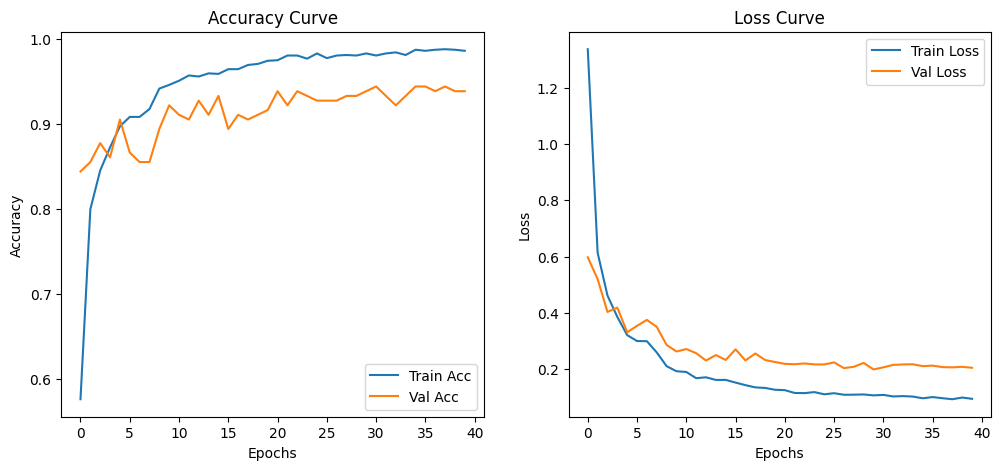


Test Classification Report:
               precision    recall  f1-score   support

         Aush     1.0000    1.0000    1.0000        20
        BR-28     0.8000    1.0000    0.8889        20
        BR-29     0.9474    0.9000    0.9231        20
        Beroi     1.0000    1.0000    1.0000        20
    Chinigura     0.9524    1.0000    0.9756        20
    Ghee Bhog     0.8636    0.9500    0.9048        20
 Katari Najir     0.9375    0.7500    0.8333        20
Katari Siddho     0.9444    0.8500    0.8947        20
      Miniket     0.9500    0.9500    0.9500        20
       Swarna     1.0000    0.9500    0.9744        20

     accuracy                         0.9350       200
    macro avg     0.9395    0.9350    0.9345       200
 weighted avg     0.9395    0.9350    0.9345       200



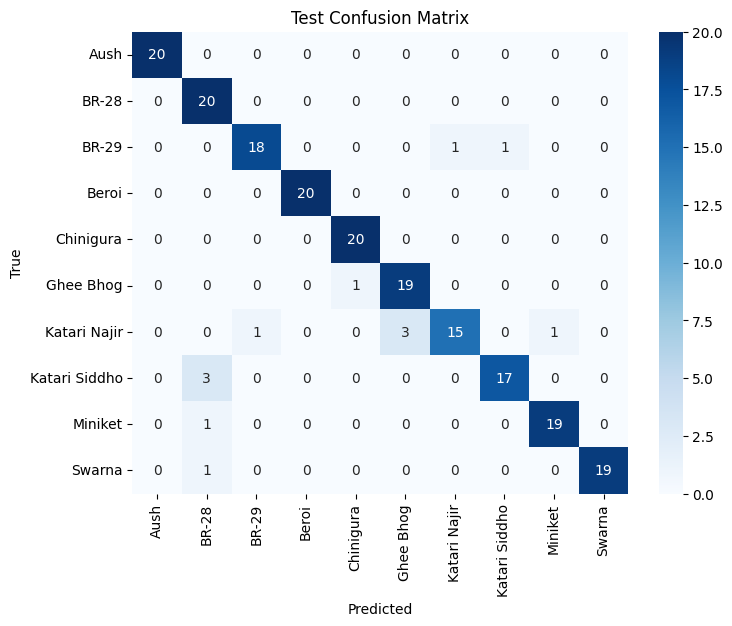

Aush Accuracy: 1.0000
BR-28 Accuracy: 1.0000
BR-29 Accuracy: 0.9000
Beroi Accuracy: 1.0000
Chinigura Accuracy: 1.0000
Ghee Bhog Accuracy: 0.9500
Katari Najir Accuracy: 0.7500
Katari Siddho Accuracy: 0.8500
Miniket Accuracy: 0.9500
Swarna Accuracy: 0.9500
Macro Precision: 0.9395
Macro Recall: 0.9350
Macro F1-score: 0.9345

Per-Class Metrics:
Aush: Precision=1.0000, Recall=1.0000, F1=1.0000
BR-28: Precision=0.8000, Recall=1.0000, F1=0.8889
BR-29: Precision=0.9474, Recall=0.9000, F1=0.9231
Beroi: Precision=1.0000, Recall=1.0000, F1=1.0000
Chinigura: Precision=0.9524, Recall=1.0000, F1=0.9756
Ghee Bhog: Precision=0.8636, Recall=0.9500, F1=0.9048
Katari Najir: Precision=0.9375, Recall=0.7500, F1=0.8333
Katari Siddho: Precision=0.9444, Recall=0.8500, F1=0.8947
Miniket: Precision=0.9500, Recall=0.9500, F1=0.9500
Swarna: Precision=1.0000, Recall=0.9500, F1=0.9744


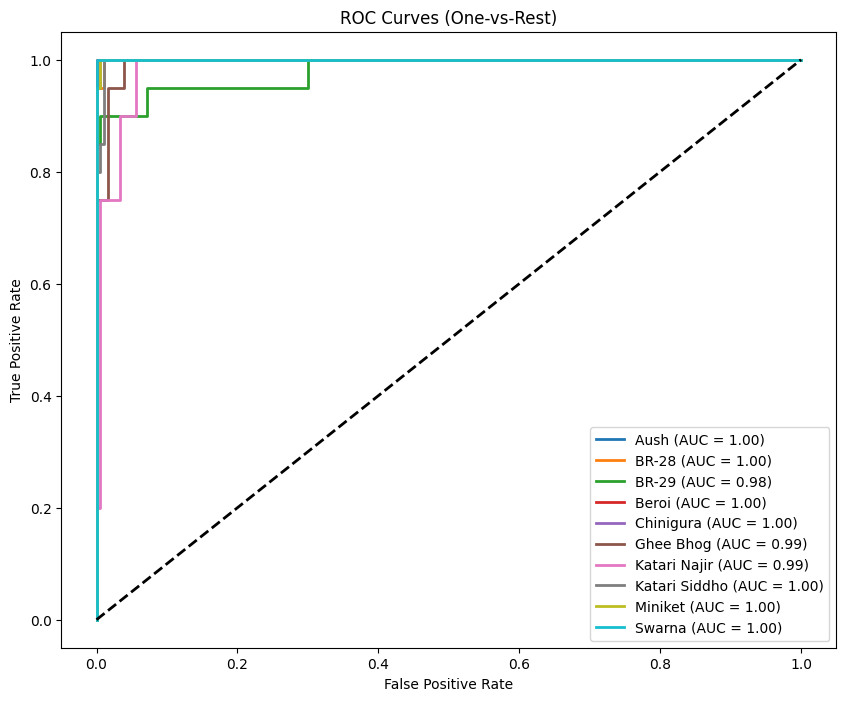

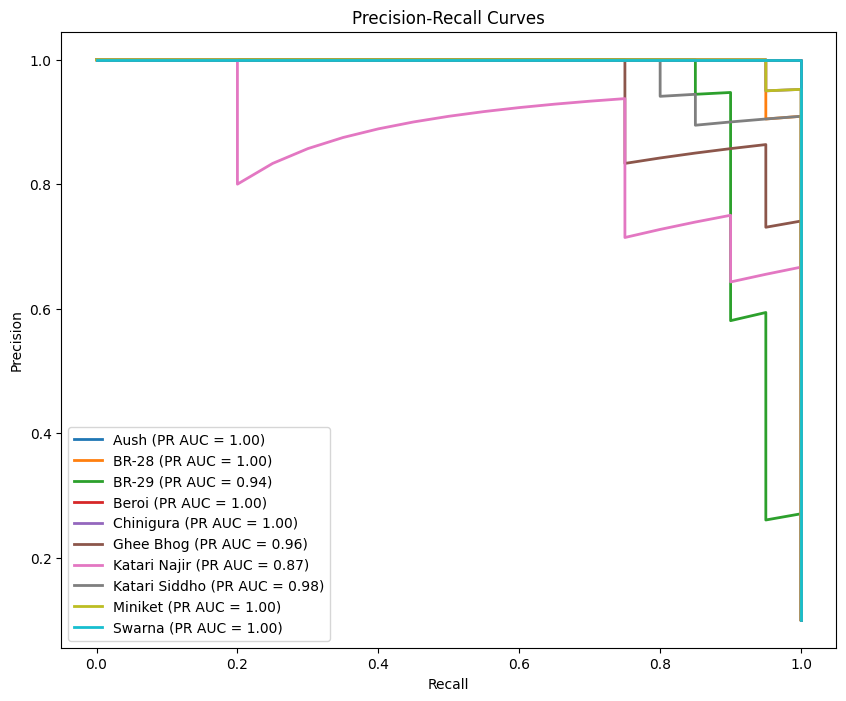

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Total inference time: 26.53 sec
Inference time per sample: 0.132641 sec

Most confused class pairs:
Aush is most often confused with Aush (0 samples)
BR-28 is most often confused with Aush (0 samples)
BR-29 is most often confused with Katari Najir (1 samples)
Beroi is most often confused with Aush (0 samples)
Chinigura is most often confused with Aush (0 samples)
Ghee Bhog is most often confused with Chinigura (1 samples)
Katari Najir is most often confused with Ghee Bhog (3 samples)
Katari Siddho is most often confused with BR-28 (3 samples)
Miniket is most often confused with BR-28 (1 samples)
Swarna is most often confused with BR-28 (1 samples)


In [20]:
import os
import time
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import label_binarize
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

# -----------------------------
# Paths and parameters
# -----------------------------
split_base_dir = '/kaggle/working/split_data'
dataset_dir = "/root/.cache/kagglehub/datasets/nuranfarhanaprova/processed-rice-varieties-of-bangladesh/versions/1/Original_Images"
img_size = (224, 224)
batch_size = 32
num_classes = 10
classes = sorted([d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))])

# -----------------------------
# Data generators
# -----------------------------
datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_directory(
    os.path.join(split_base_dir, 'train'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    os.path.join(split_base_dir, 'val'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_gen = datagen.flow_from_directory(
    os.path.join(split_base_dir, 'test'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# -----------------------------
# Model: DenseNet121
# -----------------------------
def build_densenet_model(input_shape=(224,224,3), num_classes=10, dropout_rate=0.3, l2_reg=1e-4):
    base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(l2_reg))(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=outputs)
    return model

densenet_model = build_densenet_model(num_classes=num_classes)
densenet_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# -----------------------------
# Callbacks
# -----------------------------
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# -----------------------------
# Training
# -----------------------------
start_time = time.time()
history = densenet_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=40,
    callbacks=[reduce_lr],
    verbose=2
)
training_time = time.time() - start_time

# -----------------------------
# Plot training curves
# -----------------------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# -----------------------------
# Evaluation function
# -----------------------------
def evaluate_model(generator, model):
    steps = int(np.ceil(generator.samples / generator.batch_size))
    y_true = []
    y_pred_prob = []
    for _ in range(steps):
        x_batch, y_batch = next(generator)
        preds = model.predict(x_batch, verbose=0)
        y_true.append(y_batch)
        y_pred_prob.append(preds)
    y_true = np.vstack(y_true)
    y_pred_prob = np.vstack(y_pred_prob)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true_labels = np.argmax(y_true, axis=1)
    return y_true_labels, y_pred, y_true, y_pred_prob

train_true, train_pred, train_true_prob, train_pred_prob = evaluate_model(train_gen, densenet_model)
val_true, val_pred, val_true_prob, val_pred_prob = evaluate_model(val_gen, densenet_model)
test_true, test_pred, test_true_prob, test_pred_prob = evaluate_model(test_gen, densenet_model)

# -----------------------------
# Reports
# -----------------------------
print("\nTest Classification Report:")
print(classification_report(test_true, test_pred, digits=4, target_names=classes))

cm = confusion_matrix(test_true, test_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Test Confusion Matrix')
plt.show()

# Per-class accuracy
per_class_acc = cm.diagonal() / cm.sum(axis=1)
for cls, acc in zip(classes, per_class_acc):
    print(f"{cls} Accuracy: {acc:.4f}")

# Precision, Recall, F1-score
macro_precision = precision_score(test_true, test_pred, average='macro')
macro_recall = recall_score(test_true, test_pred, average='macro')
macro_f1 = f1_score(test_true, test_pred, average='macro')
print(f"Macro Precision: {macro_precision:.4f}")
print(f"Macro Recall: {macro_recall:.4f}")
print(f"Macro F1-score: {macro_f1:.4f}\n")

# Per-class metrics
per_class_precision = precision_score(test_true, test_pred, average=None)
per_class_recall = recall_score(test_true, test_pred, average=None)
per_class_f1 = f1_score(test_true, test_pred, average=None)
print("Per-Class Metrics:")
for i, cls in enumerate(classes):
    print(f"{cls}: Precision={per_class_precision[i]:.4f}, Recall={per_class_recall[i]:.4f}, F1={per_class_f1[i]:.4f}")

# ROC–AUC Curves (One-vs-Rest)
y_true_bin = label_binarize(test_true, classes=range(num_classes))
plt.figure(figsize=(10,8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], test_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{classes[i]} (AUC = {roc_auc:.2f})')
plt.plot([0,1],[0,1],'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (One-vs-Rest)')
plt.legend(loc='lower right')
plt.show()

# Precision-Recall Curves
plt.figure(figsize=(10,8))
for i in range(num_classes):
    precision_vals, recall_vals, _ = precision_recall_curve(y_true_bin[:, i], test_pred_prob[:, i])
    pr_auc = auc(recall_vals, precision_vals)
    plt.plot(recall_vals, precision_vals, lw=2, label=f'{classes[i]} (PR AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc='lower left')
plt.show()

# -----------------------------
# Testing / Inference time per sample
# -----------------------------
start_infer = time.time()
_ = densenet_model.predict(test_gen, verbose=0)
total_infer_time = time.time() - start_infer
time_per_sample = total_infer_time / test_gen.samples
print(f"Total inference time: {total_infer_time:.2f} sec")
print(f"Inference time per sample: {time_per_sample:.6f} sec")

# -----------------------------
# Failure modes: most confused class pairs
# -----------------------------
cm_df = pd.DataFrame(confusion_matrix(test_true, test_pred), index=classes, columns=classes)
print("\nMost confused class pairs:")
for cls in classes:
    row = cm_df.loc[cls].copy()
    row[cls] = 0
    most_confused = row.idxmax()
    print(f"{cls} is most often confused with {most_confused} ({row.max()} samples)")


In [21]:
# Calculate and print the number of parameters
total_params = densenet_model.count_params()
trainable_params = sum([tf.keras.backend.count_params(w) for w in densenet_model.trainable_weights]) # Corrected to use densenet_model weights
non_trainable_params = sum([tf.keras.backend.count_params(w) for w in densenet_model.non_trainable_weights]) # Corrected to use densenet_model weights

print(f"Total Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")
print(f"Non-Trainable Parameters: {non_trainable_params:,}")

Total Parameters: 7,567,434
Trainable Parameters: 529,930
Non-Trainable Parameters: 7,037,504


Macro Precision: 0.9395
Macro Recall: 0.9350
Macro F1-score: 0.9345

Per-Class Metrics:
Aush: Precision=1.0000, Recall=1.0000, F1=1.0000
BR-28: Precision=0.8000, Recall=1.0000, F1=0.8889
BR-29: Precision=0.9474, Recall=0.9000, F1=0.9231
Beroi: Precision=1.0000, Recall=1.0000, F1=1.0000
Chinigura: Precision=0.9524, Recall=1.0000, F1=0.9756
Ghee Bhog: Precision=0.8636, Recall=0.9500, F1=0.9048
Katari Najir: Precision=0.9375, Recall=0.7500, F1=0.8333
Katari Siddho: Precision=0.9444, Recall=0.8500, F1=0.8947
Miniket: Precision=0.9500, Recall=0.9500, F1=0.9500
Swarna: Precision=1.0000, Recall=0.9500, F1=0.9744


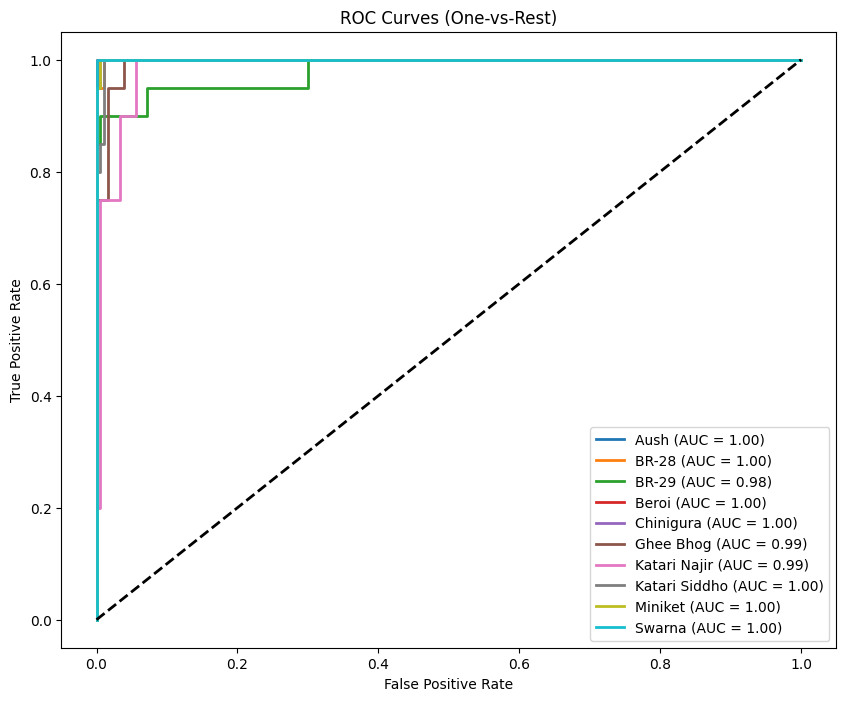

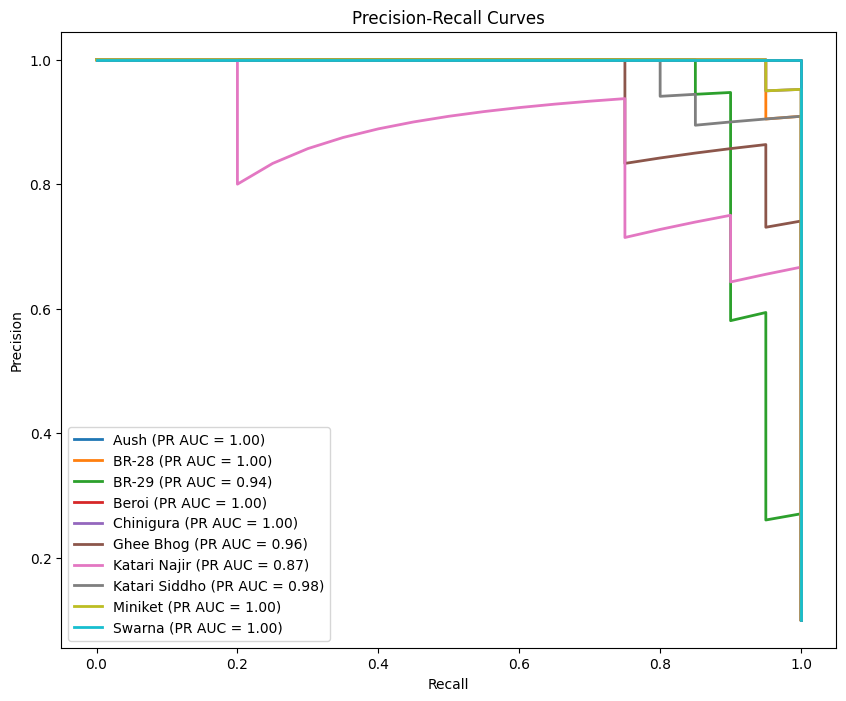


Test AUC: 0.9959
Test PR AUC: 0.9744

Most Confused Class Pairs:
Aush is most often confused with Aush (0 samples)
BR-28 is most often confused with Aush (0 samples)
BR-29 is most often confused with Katari Najir (1 samples)
Beroi is most often confused with Aush (0 samples)
Chinigura is most often confused with Aush (0 samples)
Ghee Bhog is most often confused with Chinigura (1 samples)
Katari Najir is most often confused with Ghee Bhog (3 samples)
Katari Siddho is most often confused with BR-28 (3 samples)
Miniket is most often confused with BR-28 (1 samples)
Swarna is most often confused with BR-28 (1 samples)


In [22]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve, confusion_matrix, average_precision_score # Add average_precision_score import
from sklearn.preprocessing import label_binarize
import pandas as pd
import matplotlib.pyplot as plt
import time # Add time import
import numpy as np # Add numpy import

# -----------------------------
# Precision, Recall, F1-score
# -----------------------------
macro_precision = precision_score(test_true, test_pred, average='macro')
macro_recall = recall_score(test_true, test_pred, average='macro')
macro_f1 = f1_score(test_true, test_pred, average='macro')

print(f"Macro Precision: {macro_precision:.4f}")
print(f"Macro Recall: {macro_recall:.4f}")
print(f"Macro F1-score: {macro_f1:.4f}\n")

# Per-class scores
per_class_precision = precision_score(test_true, test_pred, average=None)
per_class_recall = recall_score(test_true, test_pred, average=None)
per_class_f1 = f1_score(test_true, test_pred, average=None)

print("Per-Class Metrics:")
for i, cls in enumerate(classes):
    print(f"{cls}: Precision={per_class_precision[i]:.4f}, Recall={per_class_recall[i]:.4f}, F1={per_class_f1[i]:.4f}")

# -----------------------------
# ROC–AUC Curves (One-vs-Rest)
# -----------------------------
y_true_bin = label_binarize(test_true, classes=range(num_classes))

plt.figure(figsize=(10,8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], test_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{classes[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (One-vs-Rest)')
plt.legend(loc='lower right')
plt.show()

# -----------------------------
# Precision-Recall Curves
# -----------------------------
plt.figure(figsize=(10,8))
for i in range(num_classes):
    precision_vals, recall_vals, _ = precision_recall_curve(y_true_bin[:, i], test_pred_prob[:, i])
    pr_auc = auc(recall_vals, precision_vals)
    plt.plot(recall_vals, precision_vals, lw=2, label=f'{classes[i]} (PR AUC = {pr_auc:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc='lower left')
plt.show()

# AUC & PR
print(f"\nTest AUC: {roc_auc_score(test_true_prob, test_pred_prob, average='macro', multi_class='ovr'):.4f}") # Add AUC
print(f"Test PR AUC: {average_precision_score(test_true_prob, test_pred_prob, average='macro'):.4f}") # Add PR AUC


# -----------------------------
# Failure Modes: Most Confused Class Pairs
# -----------------------------
cm_df = pd.DataFrame(confusion_matrix(test_true, test_pred), index=classes, columns=classes)

print("\nMost Confused Class Pairs:")
for cls in classes:
    row = cm_df.loc[cls].copy()
    row[cls] = 0  # Ignore correct predictions
    most_confused = row.idxmax()
    print(f"{cls} is most often confused with {most_confused} ({row.max()} samples)")